# 🔧 Task 1: Data Preprocessing – Filtering & Cleaning Complaint Narratives

In this section, we prepare the raw CFPB complaints dataset for semantic search by processing it in chunks. Due to the file's large size (5.3 GB), we apply filtering and cleaning in a memory-efficient way. We:
- Filter for five product categories: Credit card, Personal loan, BNPL, Savings account, and Money transfers
- Drop complaints without consumer narratives
- Clean the narrative text (lowercase, remove boilerplate and special characters)
The cleaned and filtered output is saved to `data/filtered_complaints.csv` for further analysis and embedding.


In [12]:
# 🔧 Cell 1: Import libraries & define paths
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm


RAW_DATA_PATH = "../data/complaints.csv"   # ✅ correct relative path
OUTPUT_PATH = "../data/filtered_complaints.csv"


In [13]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    
    text = text.lower()
    # Remove boilerplate patterns
    text = re.sub(r'i am writing.*?complaint', '', text)
    text = re.sub(r'to whom it may concern', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [14]:
product_counts = product_sample["Product"].value_counts()

print("🔍 Unique products found in the raw dataset:\n")
print(product_counts)

🔍 Unique products found in the raw dataset:

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                            

In [15]:
# 🎯 Updated product labels from the dataset
TARGET_PRODUCTS = {
    "Credit card",
    "Payday loan, title loan, or personal loan",
    "Payday loan, title loan, personal loan, or advance loan",
    "Checking or savings account",
    "Money transfer, virtual currency, or money service"
}

# Ensure output folder exists
os.makedirs("data", exist_ok=True)

# Chunk processing to handle large files
first_write = True
chunk_size = 100000

for chunk in tqdm(pd.read_csv(RAW_DATA_PATH, chunksize=chunk_size)):
    # Filter to relevant products
    chunk = chunk[chunk['Product'].isin(TARGET_PRODUCTS)]
    
    # Drop missing narratives
    chunk = chunk.dropna(subset=['Consumer complaint narrative'])
    
    # Clean the narratives
    chunk['Cleaned Narrative'] = chunk['Consumer complaint narrative'].apply(clean_text)
    
    # Save in append mode
    if first_write:
        chunk.to_csv(OUTPUT_PATH, index=False, mode='w')
        first_write = False
    else:
        chunk.to_csv(OUTPUT_PATH, index=False, mode='a', header=False)


1it [00:00,  3.24it/s]C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
2it [00:00,  2.99it/s]C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
4it [00:01,  2.84it/s]C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
5it [00:01,  2.50it/s]C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
84it [01:42,  1.03it/s]C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\std.py:1181: DtypeWar

# 📊 Task 1: Exploratory Data Analysis (EDA)

With the cleaned dataset in hand, we now explore the structure and characteristics of the complaint narratives. This includes:
- Distribution of complaints across the five product categories
- Word count statistics to assess narrative length
- Visualization of complaint lengths
- Identification of very short and very long narratives
These insights help us understand the data’s complexity and inform future steps like chunking for embedding.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filtered_path = "../data/filtered_complaints.csv"
df = pd.read_csv(filtered_path)

df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Cleaned Narrative
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,a xxxx xxxx card was opened under my name by a...
1,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,ID,83815,NaN,Consent provided,Web,2025-06-13,Closed with explanation,Yes,NaN,14061897,i made the mistake of using my wellsfargo debi...
2,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,dear cfpb i have a secured credit card with ci...
3,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,i have a citi rewards cards the credit balance...
4,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,bi am writing to dispute the following charges...


C:\Users\HP\AppData\Local\Temp\ipykernel_16992\2127726799.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Product', order=df['Product'].value_counts().index, palette='viridis')


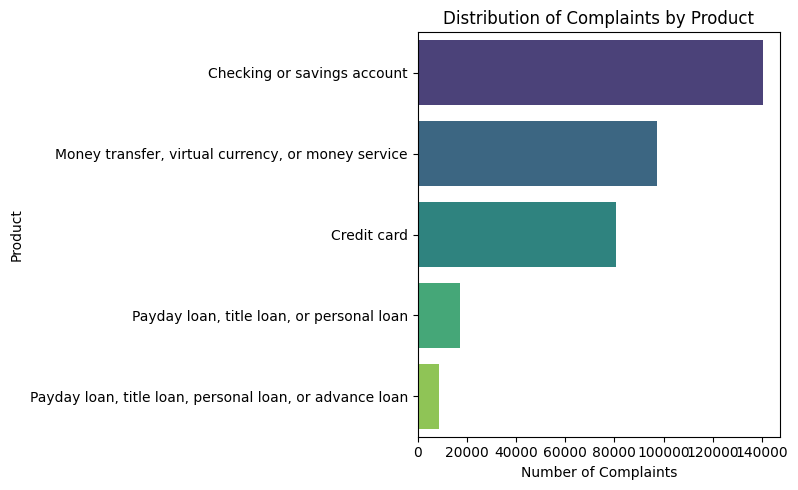

In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y='Product', order=df['Product'].value_counts().index, palette='viridis')
plt.title("Distribution of Complaints by Product")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

In [18]:
df["Narrative Word Count"] = df["Cleaned Narrative"].apply(lambda x: len(str(x).split()))
df["Narrative Word Count"].describe()


count    344308.000000
mean        195.480831
std         221.265472
min           1.000000
25%          80.000000
50%         125.000000
75%         241.000000
max        6469.000000
Name: Narrative Word Count, dtype: float64

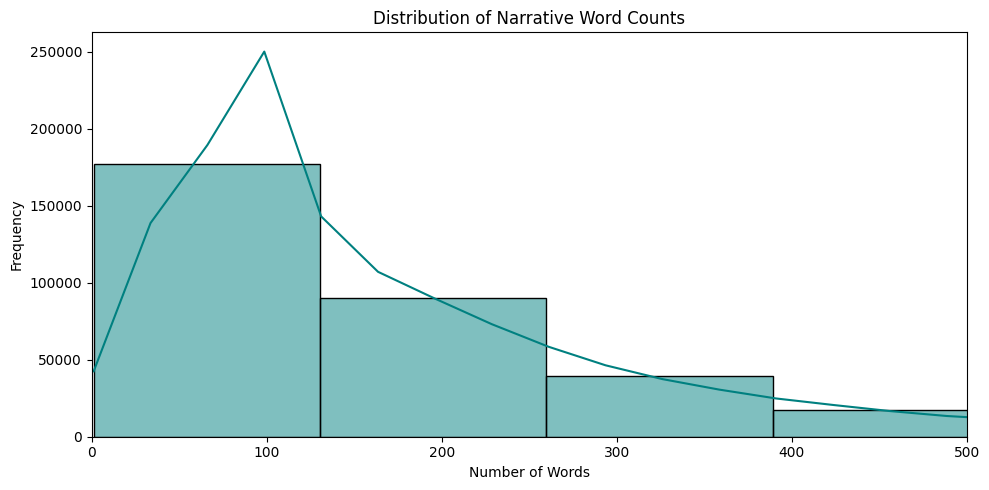

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Narrative Word Count"], bins=50, kde=True, color='teal')
plt.title("Distribution of Narrative Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xlim(0, 500)  # Trim out long-tail outliers
plt.tight_layout()
plt.show()


In [20]:
short_narratives = df[df["Narrative Word Count"] < 10]
long_narratives = df[df["Narrative Word Count"] > 500]

print(f"Total complaints: {len(df)}")
print(f"Very short narratives (<10 words): {len(short_narratives)}")
print(f"Very long narratives (>500 words): {len(long_narratives)}")


Total complaints: 344308
Very short narratives (<10 words): 1720
Very long narratives (>500 words): 22468
